In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("data/binary_data.csv")
X = df.drop(['id', 'traffic_type', 'src_ip', 'dst_ip'], axis=1)
y = df['traffic_type']

kfold = KFold(n_splits=5)

In [3]:
print(X.columns)

Index(['expiration_id', 'src_ip_is_private', 'src_port', 'dst_ip_is_private',
       'dst_port', 'protocol', 'ip_version', 'vlan_id',
       'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
       'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
       'dst2src_first_seen_ms', 'dst2src_last_seen_ms', 'dst2src_duration_ms',
       'dst2src_packets', 'dst2src_bytes', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps',
       'src2dst_stddev_ps', 'src2dst_max_ps', 'dst2src_min_ps',
       'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 's

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5; 1/45] START classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5
[CV 1/5; 1/45] END classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5;, score=1.000 total time=   0.8s
[CV 2/5; 1/45] START classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5
[CV 2/5; 1/45] END classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5;, score=1.000 total time=   0.5s
[CV 3/5; 1/45] START classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5
[CV 3/5; 1/45] END classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5;, score=1.000 total time=   0.4s
[CV 4/5; 1/45] START classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5
[CV 4/5; 1/45] END classifier__max_depth=3, classifier__n_estimators=100, pca__n_components=5;, score=1.000 total time=   0.5s
[CV 5/5; 1/45] START classifier__max_depth=3, 

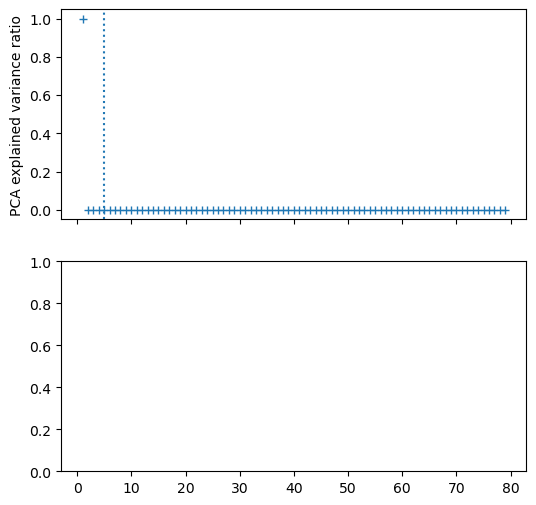

In [4]:
pca = PCA()
classifier = XGBClassifier(learning_rate = 0.1,
                           verbose=None,
                           eval_metric='logloss', 
                           tree_method="gpu_hist")

pipe = Pipeline(steps=[("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "classifier__n_estimators": np.arange(100, 250, 50),
    "classifier__max_depth": np.arange(3, 6)
}
search = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)